# Pre-process data from multipe datasets to get data max temp stats over South America

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import intake
# import uxarray as ux
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import healpix as hp
import easygems.healpix as egh
import easygems as egm
# from easygems.spatial import clip_lat_lon_bounds

## Compare datasets based on availability in the HEALPix format

| Dataset   | Variable           | Long Name                            | Units           | Frequency available | Comments                                                        |
|-----------|--------------------|--------------------------------------|-----------------|-----------|-----------------------------------------------------------------|
| ERA5      | `T`   |  temps                 | K              | hourly | Reanalysis  

| WRF-SAAG  | `tas`               | Surface air emps            | K     | Hourly    | WRF output|

In [2]:
# Define the period of interest
start, end = '2020-01-01', '2020-12-31'

In [3]:
cat_url = "https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml"
cat = intake.open_catalog(cat_url).NCAR
cat

NCAR:
  args:
    path: https://digital-earths-global-hackathon.github.io/catalog/NCAR/catalog.yaml
  description: catalog as visible from NCAR
  driver: intake.catalog.local.YAMLFileCatalog
  metadata:
    catalog_dir: https://digital-earths-global-hackathon.github.io/catalog


In [4]:
list(cat)

['CERES_EBAF',
 'ERA5',
 'IR_IMERG',
 'JRA3Q',
 'MERRA2',
 'arp-gem-1p3km',
 'arp-gem-2p6km',
 'casesm2_10km_nocumulus',
 'ew_dyamond3_2D',
 'icon_d3hp003',
 'icon_d3hp003aug',
 'icon_d3hp003feb',
 'icon_ngc4008',
 'ifs_tco3999-ng5_deepoff',
 'ifs_tco3999-ng5_rcbmf',
 'ifs_tco3999-ng5_rcbmf_cf',
 'ifs_tco3999_rcbmf',
 'mpas_dyamond1',
 'mpas_dyamond2',
 'mpas_dyamond3',
 'nicam_220m_test',
 'nicam_gl11',
 'scream-dkrz',
 'scream2D_hrly',
 'scream_lnd',
 'scream_ne120',
 'tracking-d3hp003',
 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_glm_n1280_CoMA9_TBv1p2',
 'um_glm_n1280_GAL9',
 'um_glm_n2560_RAL3p3',
 'wrf_conus',
 'wrf_samerica']

## Get max temp data from different models and obs

### Obtain data

#### WRF -South America data

In [5]:
zoom_level = 9

In [6]:
%%time
ds_wrf_saag = cat.wrf_samerica(zoom=zoom_level).to_dask()
da_wrf_saag = ds_wrf_saag.tas
da_wrf_saag = da_wrf_saag.rename({'Time':'time'})

CPU times: user 1.64 s, sys: 124 ms, total: 1.76 s
Wall time: 1.89 s


/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [7]:
da_wrf_saag = da_wrf_saag.sel(time=slice(start,end))
da_wrf_saag

<xarray.DataArray 'tas' (time: 8784, cell: 394546)> Size: 14GB
dask.array<getitem, shape=(8784, 394546), dtype=float32, chunksize=(48, 65536), chunktype=numpy.ndarray>
Coordinates:
  * cell     (cell) int64 3MB 786432 786433 786434 ... 3145725 3145726 3145727
    crs      float32 4B nan
  * time     (time) datetime64[ns] 70kB 2020-01-01 ... 2020-12-31T23:00:00
Attributes:
    description:       Air temperature at the lowest model level
    domain_extent:     (np.float32(-98.46912), np.float32(-17.530884), np.flo...
    grid_mapping:      healpix_nested
    healpix_nside:     512
    quantization:      quantization_info
    quantization_nsd:  5
    regrid_method:     easygems_delaunay
    stagger:           
    units:             K

In [8]:
# np.set_printoptions(threshold=np.inf)

#### ERA5 data

In [9]:
cat_era5 = intake.open_esm_datastore('/glade/campaign/collections/rda/data/d850001/catalogs/posix/era5/era5_catalog_posix.json')
# cat_era5.df[['variable','long_name']].values

/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/intake_esm/cat.py:249: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [10]:
cat_temp_era5 = cat_era5.search(variable='VAR_2T',frequency='hourly',year=2020)
cat_temp_era5

,unique
Unnamed: 0,12
era_id,1
datatype,1
level_type,0
step_type,1
table_code,1
param_code,1
variable,1
long_name,1
units,1


In [11]:
dsets_era5 = cat_temp_era5.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'datatype.step_type'


In [12]:
dsets_era5.keys()

dict_keys(['an.sfc'])

In [13]:
da_era5 = dsets_era5['an.sfc']
da_era5 = da_era5.VAR_2T

In [14]:
# da_era5['latitude'] = da_era5['latitude'].assign_attrs(standard_name='latitude') 
# da_era5['longitude'] = da_era5['longitude'].assign_attrs(standard_name='longitude') 
# print(da_era5['latitude'].attrs,da_era5['longitude'].attrs)

In [15]:
# ux_era5     = ux.UxDataset.from_structured(da_era5.to_dataset(name='T'))
# ux_wrf_saag = ux.UxDataset.from_healpix(da_wrf_saag.to_dataset(name='T'))

In [16]:
# %%time
# ux_era5

In [17]:
# # 2. Pull out the UxDataArray for each variable
# da_era5_ux  = ux_era5['T']
# da_wrf_ux   = ux_wrf_saag['T']
# da_wrf_ux

### Subset to South America

In [18]:
# 3. Define South America bounding box and subset
lon_bounds = (-90, -30)
lat_bounds = (-60,  15)
#
lat_start = 15
lat_end   = -60
lon_start = (360-90)%360
lon_end   = (360-30)%360
lon_end

330

In [19]:
sa_era5 = da_era5.sel(latitude = slice(lat_start,lat_end),longitude= slice(lon_start,lon_end))
sa_era5

<xarray.DataArray 'VAR_2T' (time: 8784, latitude: 301, longitude: 241)> Size: 3GB
dask.array<getitem, shape=(8784, 301, 241), dtype=float32, chunksize=(27, 133, 193), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 2kB 15.0 14.75 14.5 ... -59.5 -59.75 -60.0
  * longitude  (longitude) float64 2kB 270.0 270.2 270.5 ... 329.5 329.8 330.0
  * time       (time) datetime64[ns] 70kB 2020-01-01 ... 2020-12-31T23:00:00
    utc_date   (time) int32 35kB dask.array<chunksize=(744,), meta=np.ndarray>
Attributes:
    long_name:                     2 metre temperature
    short_name:                    2t
    units:                         K
    original_format:               WMO GRIB 1 with ECMWF local table
    ecmwf_local_table:             128
    ecmwf_parameter:               167
    grid_specification:            0.25 degree x 0.25 degree from 90N to 90S ...
    rda_dataset:                   ds633.0
    rda_dataset_url:               https:/rda.ucar.edu/datasets/ds633.0/
    rda_dataset_doi:               DOI: 10.5065/BH6N-5N20
    rda_dataset_group:             ERA5 atmospheric surface analysis [netCDF4]
    number_of_significant_digits:  7

In [20]:
da_wrf_saag

<xarray.DataArray 'tas' (time: 8784, cell: 394546)> Size: 14GB
dask.array<getitem, shape=(8784, 394546), dtype=float32, chunksize=(48, 65536), chunktype=numpy.ndarray>
Coordinates:
  * cell     (cell) int64 3MB 786432 786433 786434 ... 3145725 3145726 3145727
    crs      float32 4B nan
  * time     (time) datetime64[ns] 70kB 2020-01-01 ... 2020-12-31T23:00:00
Attributes:
    description:       Air temperature at the lowest model level
    domain_extent:     (np.float32(-98.46912), np.float32(-17.530884), np.flo...
    grid_mapping:      healpix_nested
    healpix_nside:     512
    quantization:      quantization_info
    quantization_nsd:  5
    regrid_method:     easygems_delaunay
    stagger:           
    units:             K

In [21]:
print(sa_era5.attrs.get("units", "no units attribute"))

K


In [22]:
# %%time
# # Check easy gem plot
# projection = ccrs.Robinson()
# fig, ax = plt.subplots(
#     figsize=(8, 4), subplot_kw={"projection": projection})

# ax.set_extent([lon_start, lon_end, lat_end, lat_start], crs=ccrs.PlateCarree())

# egh.healpix_show(da_wrf_saag.isel(time=1), ax=ax)
# #egh.healpix_show(sa_era5.isel(time=1), ax=ax)
# ax.add_feature(cf.COASTLINE, linewidth=0.8)
# ax.add_feature(cf.BORDERS, linewidth=0.4)

Text(0.5, 1.0, 'ERA5: Test plot of temps')

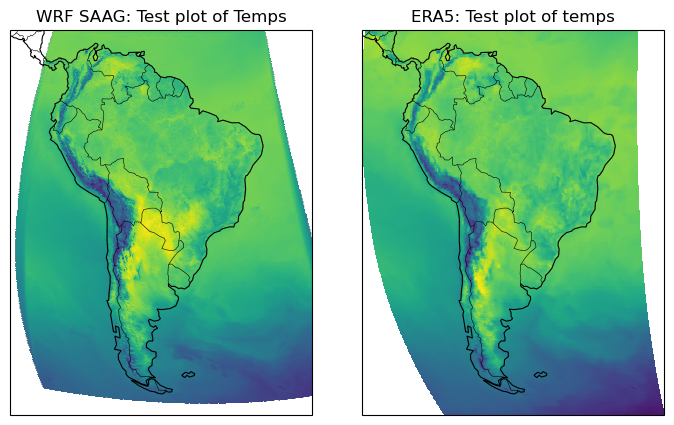

/glade/u/apps/opt/conda/envs/2025-digital-earths-global-hackathon/lib/python3.12/site-packages/dask/array/reductions.py:324: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


In [23]:
fig, axs = plt.subplots(
    ncols=2, figsize=(9, 5),
    subplot_kw={'projection': ccrs.Robinson()},
    gridspec_kw={'wspace': 0.02},  # reduce horizontal space
    constrained_layout=False  # disable to regain spacing control
)

# Define plot bounds
axs[0].set_extent([lon_start, lon_end, lat_end, lat_start], crs=ccrs.PlateCarree())
axs[1].set_extent([lon_start, lon_end, lat_end, lat_start], crs=ccrs.PlateCarree())

# WRF (unstructured)
egh.healpix_show(da_wrf_saag.isel(time=1), ax=axs[0])
axs[0].add_feature(cf.COASTLINE, linewidth=0.8)
axs[0].add_feature(cf.BORDERS, linewidth=0.4)
axs[0].set_title("WRF SAAG: Test plot of Temps")

# ERA5 (structured)
sa_era5.isel(time=1).plot.pcolormesh(
    ax=axs[1],
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)
axs[1].add_feature(cf.COASTLINE, linewidth=0.8)
axs[1].add_feature(cf.BORDERS, linewidth=0.4)
axs[1].set_title("ERA5: Test plot of temps")

### Compute seasonal anomaly

In [24]:
def seasonal_max_uxarray(da, season="DJF"):
    """
    Compute seasonal max for a given season from a uxarray.DataArray,
    without adding a new coordinate.

    Parameters:
    -----------
    da : uxarray.DataArray
        Input DataArray on an unstructured mesh with a time coordinate.
    season : str
        One of ["DJF", "MAM", "JJA", "SON"]
    time_coord : str
        Name of the time coordinate in the DataArray.

    Returns:
    --------
    xr.DataArray
        Seasonal maximum temperature.
    """
    # Ensure time is datetime64
    if not np.issubdtype(da["time"].dtype, np.datetime64):
        da["time"] = xr.decode_cf(da).time

    # Use boolean indexing with dt accessor
    season_mask = da["time"].dt.season == season
    return da.sel(time=season_mask).max(dim="time")

In [25]:
def seasonal_mean_uxarray(da, season="DJF"):
    """
    Compute seasonal mean for a given season from a uxarray.DataArray,
    without adding a new coordinate.

    Parameters:
    -----------
    da : uxarray.DataArray
        Input DataArray on an unstructured mesh with a time coordinate.
    season : str
        One of ["DJF", "MAM", "JJA", "SON"]
    time_coord : str
        Name of the time coordinate in the DataArray.

    Returns:
    --------
    xr.DataArray
        Seasonal maximum temperature.
    """
    # Ensure time is datetime64
    if not np.issubdtype(da["time"].dtype, np.datetime64):
        da["time"] = xr.decode_cf(da).time

    # Use boolean indexing with dt accessor
    season_mask = da["time"].dt.season == season
    return da.sel(time=season_mask).mean(dim="time")

In [26]:
%%time
sa_wrf_djf_max = seasonal_max_uxarray(da_wrf_saag, 'DJF')
sa_era5_djf_max = seasonal_max_uxarray(sa_era5, 'DJF')
# saag_wrf_jja_max

CPU times: user 580 ms, sys: 3.45 ms, total: 583 ms
Wall time: 582 ms


In [27]:
%%time
sa_wrf_djf_mean = seasonal_mean_uxarray(da_wrf_saag, 'DJF')
sa_era5_djf_mean = seasonal_mean_uxarray(sa_era5, 'DJF')
# saagwrf_jja_mean

CPU times: user 48.6 ms, sys: 3.94 ms, total: 52.6 ms
Wall time: 51.7 ms


In [28]:
# Seasonal max - Seasonal mean
sa_wrf_djf_anomaly = sa_wrf_djf_max - sa_wrf_djf_mean
sa_era5_djf_anomaly = sa_era5_djf_max - sa_era5_djf_mean

CPU times: user 16.9 s, sys: 1.13 s, total: 18.1 s
Wall time: 30.2 s


Text(0.5, 1.0, 'ERA5: DJF seasonal max - mean')

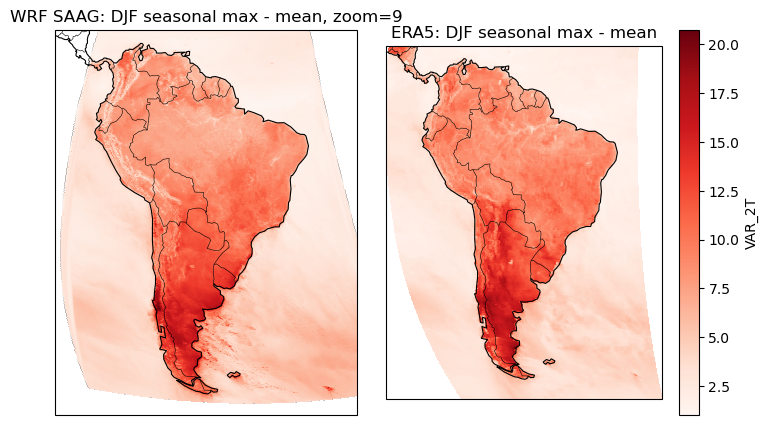

In [29]:
%%time
fig, axs = plt.subplots(
    ncols=2, figsize=(9, 5),
    subplot_kw={'projection': ccrs.Robinson()},
    gridspec_kw={'wspace': 0.02},  # reduce horizontal space
    constrained_layout=False  # disable to regain spacing control
)

# Define plot bounds
axs[0].set_extent([lon_start, lon_end, lat_end, lat_start], crs=ccrs.PlateCarree())
axs[1].set_extent([lon_start, lon_end, lat_end, lat_start], crs=ccrs.PlateCarree())

# WRF (unstructured)
egh.healpix_show(sa_wrf_djf_anomaly, ax=axs[0],cmap='Reds')
axs[0].add_feature(cf.COASTLINE, linewidth=0.8)
axs[0].add_feature(cf.BORDERS, linewidth=0.4)
axs[0].set_title("WRF SAAG: DJF seasonal max - mean, zoom=9")

# ERA5 (structured)
sa_era5_djf_anomaly.plot.pcolormesh(
    ax=axs[1],
    transform=ccrs.PlateCarree(),cmap='Reds',
    add_colorbar=True
)
axs[1].add_feature(cf.COASTLINE, linewidth=0.8)
axs[1].add_feature(cf.BORDERS, linewidth=0.4)
axs[1].set_title("ERA5: DJF seasonal max - mean")

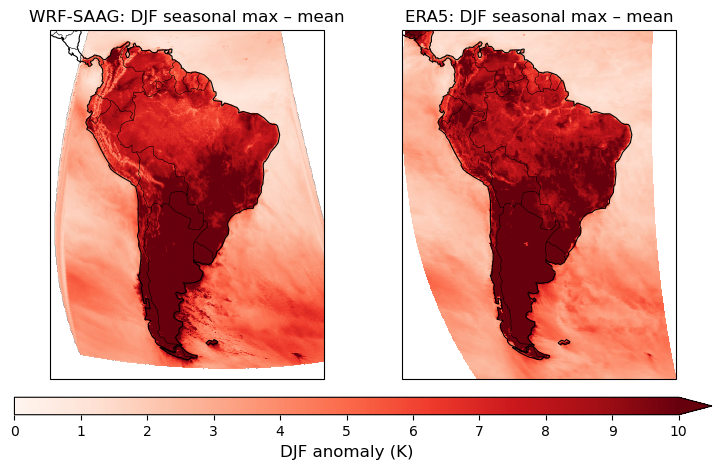

CPU times: user 18.3 s, sys: 655 ms, total: 19 s
Wall time: 27.5 s


In [31]:
%%time
# 1) Set up a 2×2 GridSpec: 
#    - top row: two equal-width map panels
#    - bottom row: one colorbar spanning both columns
fig = plt.figure(figsize=(9, 5))
gs = fig.add_gridspec(
    nrows=2, ncols=2,
    height_ratios=[1, 0.05],
    width_ratios =[1, 1],
    hspace=0.1, wspace=0.02
)

ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson())
ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.Robinson())
cax = fig.add_subplot(gs[1, :])  # bottom row, both columns

# 2) Common extent for South America
for ax in (ax0, ax1):
    ax.set_extent([lon_start, lon_end, lat_end, lat_start],
                  crs=ccrs.PlateCarree())

# 3) Plot WRF-SAAG anomaly on ax0 (capture the mappable)
im0 = egh.healpix_show(
    sa_wrf_djf_anomaly,
    ax=ax0,
    cmap='Reds',
    vmin=0, vmax=10   # saturate at 10 K
)
ax0.add_feature(cf.COASTLINE, linewidth=0.8)
ax0.add_feature(cf.BORDERS,   linewidth=0.4)
ax0.set_title("WRF-SAAG: DJF seasonal max – mean", fontsize=12)

# 4) Plot ERA5 anomaly on ax1 (capture the QuadMesh)
im1 = sa_era5_djf_anomaly.plot.pcolormesh(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap='Reds',
    vmin=0, vmax=10,   # same range
    add_colorbar=False
)
ax1.add_feature(cf.COASTLINE, linewidth=0.8)
ax1.add_feature(cf.BORDERS,   linewidth=0.4)
ax1.set_title("ERA5: DJF seasonal max – mean", fontsize=12)

# 5) Add a single horizontal colorbar with ticks every 1 K and extend beyond 10 K
cb = fig.colorbar(
    im1,                         # use either mappable (im0 or im1)
    cax=cax,
    orientation='horizontal',
    ticks=np.arange(0, 11, 1),
    extend='max'
)
cb.set_label("DJF anomaly (K)", fontsize=12)

plt.show()

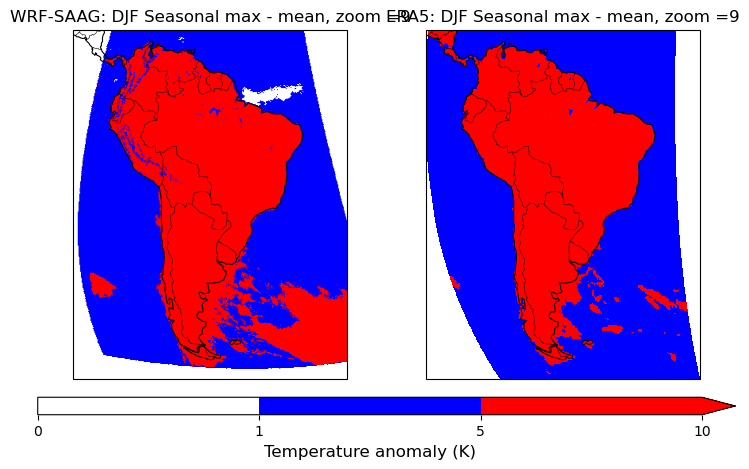

In [32]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# 1) Define a discrete colormap: white for 0, blue for 1–5 K, red for >5 K
colors = ['white', 'blue', 'red']
bounds = [0, 1, 5, 10]   # bins: [0,1), [1,5), [5,10]
cmap  = ListedColormap(colors)
norm  = BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

# 2) GridSpec with two maps + colorbar
fig = plt.figure(figsize=(9, 5))
gs = fig.add_gridspec(2, 2,
                      height_ratios=[1, 0.05],
                      width_ratios=[1, 1],
                      hspace=0.1, wspace=0.02)
ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson())
ax1 = fig.add_subplot(gs[0, 1], projection=ccrs.Robinson())
cax = fig.add_subplot(gs[1, :])  # colorbar row

# 3) Common extent
for ax in (ax0, ax1):
    ax.set_extent([lon_start, lon_end, lat_end, lat_start],
                  crs=ccrs.PlateCarree())

# 4) Plot WRF-SAAG anomaly
im0 = egh.healpix_show(
    sa_wrf_djf_anomaly,
    ax=ax0,
    cmap=cmap,
    norm=norm
)
ax0.add_feature(cf.COASTLINE, linewidth=0.8)
ax0.add_feature(cf.BORDERS,   linewidth=0.4)
ax0.set_title("WRF-SAAG: DJF Seasonal max - mean, zoom =9", fontsize=12)

# 5) Plot ERA5 anomaly
im1 = sa_era5_djf_anomaly.plot.pcolormesh(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    add_colorbar=False
)
ax1.add_feature(cf.COASTLINE, linewidth=0.8)
ax1.add_feature(cf.BORDERS,   linewidth=0.4)
ax1.set_title("ERA5: DJF Seasonal max - mean, zoom =9", fontsize=12)

# 6) Shared horizontal colorbar with 1 K steps and max‐extend
cb = fig.colorbar(
    im1, cax=cax,
    orientation='horizontal',
    ticks=bounds,
    extend='max'
)
cb.set_label("Temperature anomaly (K)", fontsize=12)

plt.show()
